#### Import packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # for encoding categorical labels
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



______________________________________________________________________________________________________________________________

## Define the dataset

In [5]:
data = pd.read_csv('sentimentdataset.csv')
df = pd.DataFrame(data)
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


_____________________________________________________________________________________________________________________

## Data Exploring: Check for null values and data types.

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB
None


_____________________________________________________________________________________________________________________________
## Data Processing

In [7]:
labelenc = LabelEncoder() #label encoder instance
df['Sentiment_encoded'] = labelenc.fit_transform(df['Sentiment'])

df['combined'] = df['Text'].astype(str) + " " + df['Hashtags'].astype(str)


vecto = TfidfVectorizer()
text_vec = vecto.fit_transform(df['combined'])

______________________________________________________________________________________________________________________________

## Summary Statistics and Hypothesis Testing

#### Distribution of sentiment in the data set.
Show how frequent each sentiment is.

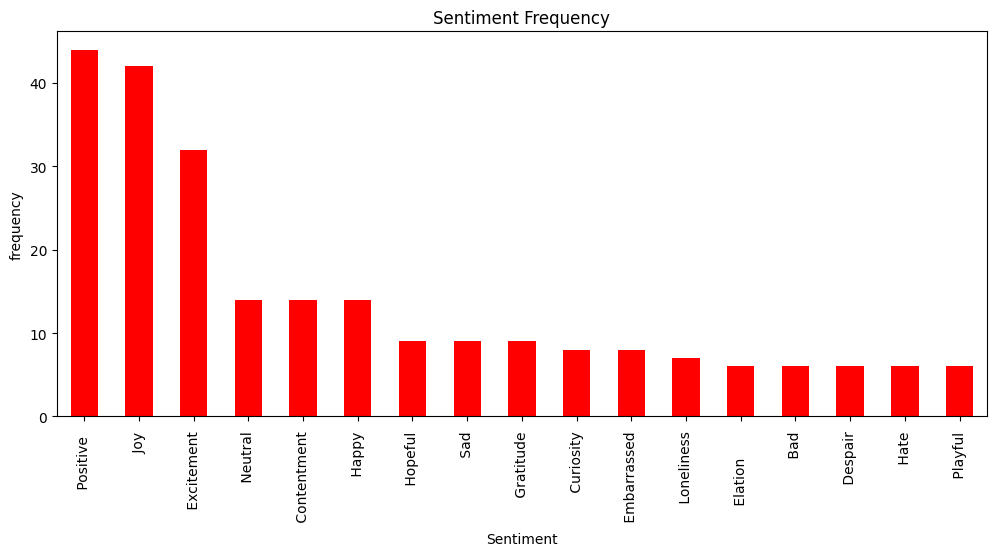

In [8]:
filtered = df['Sentiment'].value_counts()[df['Sentiment'].value_counts() > 5]
filtered.plot(kind='bar', ylabel="frequency", title="Sentiment Frequency", figsize=(12,5), color='red')
plt.show()

_________________________________________________________________________________________________________________________

## Welch’s t-test: Comparing Engagement Between Positive and Negative Posts

In this part, we wanted to see if engagement (likes + retweets) differs between positive and negative posts.
we used the *Welch t-test* because it’s designed to compare the means of two groups that might have
different variances or sample sizes.

*null hypothesis (H0):* there is no difference in average engagement between positive and negative posts.  
*alternative hypothesis (H1):* there is a difference in average engagement between the two groups.

we’ll visualize the averages first and then look at the test results to check if the difference is significant.

Welch t-test: t=9.346, p=0.0000


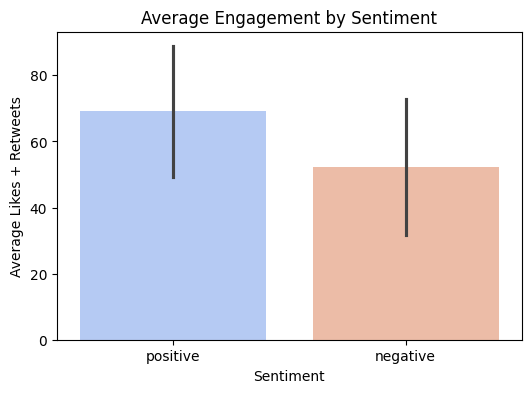

In [9]:
# getting engagement count
engagement = []
for retweet, like in zip(df['Retweets'],  df['Likes']):
    total = like + retweet
    engagement.append(total)

df['Engagement'] = engagement
df


## normalize the labels
df['Sentiment_norm'] = df['Sentiment'].astype(str).str.strip().str.lower()

## put each sentiment into buckets

pos = {
    'positive','happiness','joy','love','amusement','enjoyment','admiration',
    'affection','awe','surprise','acceptance','adoration','anticipation',
    'kind','pride','excitement','optimistic','gratitude'
}

neg = {
    'negative','anger','fear','sadness','disgust','disappointed','bitter',
    'shame'
}

neu = {'neutral', 'confusion','acceptance','calmness'}

sentiment_map = {}
sentiment_map.update({k:'positive' for k in pos})
sentiment_map.update({k:'negative' for k in neg})
sentiment_map.update({k:'netrual' for k in neu})

df['Polarity'] = df['Sentiment_norm'].map(sentiment_map)

## for sentiments that are not mapped, use vader on the text
sia = SentimentIntensityAnalyzer()
def vader_bucket(text):
    c = sia.polarity_scores(str(text))['compound']
    return 'positive' if c > 0.05 else ('negative' if c < -0.05 else 'neutral')

df.loc[df['Polarity'].isna(), 'Polarity'] = df.loc[df['Polarity'].isna(), 'Text'].apply(vader_bucket)

## keep groups with atleast 5 tweets
counts = df['Polarity'].value_counts()
keep = counts[counts >=  5].index
df_f = df[df['Polarity'].isin(keep)]

## compare the means
pos_eng = df_f.loc[df_f['Polarity'] == 'positive', 'Engagement']
neg_eng = df_f.loc[df_f['Polarity'] == 'negative', 'Engagement']

t_stat, p_val = ttest_ind(pos_eng, neg_eng, equal_var=False)

print("Welch t-test: t=%.3f, p=%.4f" % (t_stat, p_val))

df_subset = df_f[df_f['Polarity'].isin(['positive', 'negative'])]

# Plot
plt.figure(figsize=(6,4))
sns.barplot(
    data=df_subset,
    x='Polarity',
    y='Engagement',
    hue='Polarity',
    legend=False,
    errorbar='sd',
    palette='coolwarm'
)
plt.title('Average Engagement by Sentiment')
plt.ylabel('Average Likes + Retweets')
plt.xlabel('Sentiment')
plt.show()    

The bar chart shows that positive posts have noticeably higher average engagement than negative ones.
Based on the Welch’s t-test that we ran, we found that:

*t = 9.346, p = 0.0000*

Since the p-value < 0.05, we *reject the null hypothesis*.
This means the difference in engagement is statistically significant, positive posts really do get more likes
and retweets than negative ones. this supports our main hypothesis that positive sentiment leads to higher
engagement.

______________________________________________________________________________________________________________________________

## One-Way ANOVA: Comparing Sentiment Across Platforms

In this section, we wanted to see if the average sentiment differs across platforms: twitter, facebook, and instagram.  
Since we’re comparing *three groups, we used a **one-way ANOVA test*.

*null hypothesis (H0):* there is no significant difference in average sentiment between the three platforms.  
*alternative hypothesis (H1):* at least one platform’s average sentiment is significantly different from the others.

We will give each Sentiment a score of either -1 (Negative), 0 (Neutral), or 1 (Positive) based on the emotion. Then we will look at the test results to check if the difference is significant.

In [10]:
# mapping sentiment to scores (-1,0,1) for the hypothesis testing....

sentiment_scores = {
    'Acceptance': 1, 'Accomplishment': 1, 'Admiration': 1, 'Adoration': 1, 'Adrenaline': 1,
    'Adventure': 1, 'Affection': 1, 'Amazement': 1, 'Ambivalence': 0, 'Amusement': 1,
    'Anger': -1, 'Anticipation': 1, 'Anxiety': -1, 'Appreciation': 1, 'Apprehensive': -1,
    'Arousal': 0, 'ArtisticBurst': 1, 'Awe': 1, 'Bad': -1, 'Betrayal': -1, 'Bitter': -1,
    'Bitterness': -1, 'Bittersweet': 0, 'Blessed': 1, 'Boredom': -1, 'Breakthrough': 1,
    'Calmness': 1, 'Captivation': 1, 'Celebration': 1, 'Celestial Wonder': 1, 'Challenge': 0,
    'Charm': 1, 'Colorful': 1, 'Compassion': 1, 'Compassionate': 1, 'Confidence': 1,
    'Confident': 1, 'Confusion': 0, 'Connection': 1, 'Contemplation': 0, 'Contentment': 1,
    'Coziness': 1, 'Creative Inspiration': 1, 'Creativity': 1, 'Culinary Adventure': 1,
    'CulinaryOdyssey': 1, 'Curiosity': 1, 'Darkness': -1, 'Dazzle': 1, 'Desolation': -1,
    'Despair': -1, 'Desperation': -1, 'Determination': 1, 'Devastated': -1,
    'Disappointed': -1, 'Disappointment': -1, 'Disgust': -1, 'Dismissive': -1,
    'DreamChaser': 1, 'Ecstasy': 1, 'Elation': 1, 'Elegance': 1, 'Embarrassed': -1,
    'Emotion': 0, 'EmotionalStorm': -1, 'Empathetic': 1, 'Empowerment': 1, 'Enchantment': 1,
    'Energy': 1, 'Engagement': 1, 'Enjoyment': 1, 'Enthusiasm': 1, 'Envious': -1,
    'Envisioning History': 0, 'Envy': -1, 'Euphoria': 1, 'Excitement': 1, 'Exhaustion': -1,
    'Exploration': 1, 'Fear': -1, 'Fearful': -1, 'FestiveJoy': 1, 'Free-spirited': 1,
    'Freedom': 1, 'Friendship': 1, 'Frustrated': -1, 'Frustration': -1, 'Fulfillment': 1,
    'Grandeur': 1, 'Grateful': 1, 'Gratitude': 1, 'Grief': -1, 'Happiness': 1, 'Happy': 1,
    'Harmony': 1, 'Hate': -1, 'Heartache': -1, 'Heartbreak': -1, 'Heartwarming': 1,
    'Helplessness': -1, 'Hope': 1, 'Hopeful': 1, 'Hypnotic': 0, 'Iconic': 1, 'Imagination': 1,
    'Immersion': 0, 'Indifference': 0, 'InnerJourney': 1, 'Inspiration': 1, 'Inspired': 1,
    'Intimidation': -1, 'Intrigue': 1, 'Isolation': -1, 'Jealous': -1, 'Jealousy': -1,
    'Journey': 1, 'Joy': 1, 'Joy in Baking': 1, 'JoyfulReunion': 1, 'Kind': 1, 'Kindness': 1,
    'Loneliness': -1, 'Loss': -1, 'LostLove': -1, 'Love': 1, 'Marvel': 1, 'Melancholy': -1,
    'Melodic': 1, 'Mesmerizing': 1, 'Mindfulness': 1, 'Miscalculation': -1, 'Mischievous': 0,
    'Motivation': 1, "Nature's Beauty": 1, 'Negative': -1, 'Neutral': 0, 'Nostalgia': 0,
    'Numbness': 0, 'Obstacle': 0, "Ocean's Freedom": 1, 'Optimism': 1, 'Overjoyed': 1,
    'Overwhelmed': -1, 'Pensive': 0, 'Playful': 1, 'PlayfulJoy': 1, 'Positive': 1,
    'Positivity': 1, 'Pressure': -1, 'Pride': 1, 'Proud': 1, 'Radiance': 1, 'Reflection': 0,
    'Regret': -1, 'Rejuvenation': 1, 'Relief': 1, 'Renewed Effort': 1, 'Resentment': -1,
    'Resilience': 1, 'Reverence': 1, 'Romance': 1, 'Ruins': -1, 'Runway Creativity': 1,
    'Sad': -1, 'Sadness': -1, 'Satisfaction': 1, 'Serenity': 1, 'Shame': -1, 'Solace': 1,
    'Solitude': 0, 'Sorrow': -1, 'Spark': 1, 'Success': 1, 'Suffering': -1, 'Surprise': 0,
    'Suspense': 0, 'Sympathy': 1, 'Tenderness': 1, 'Thrill': 1, 'Thrilling Journey': 1,
    'Touched': 1, 'Tranquility': 1, 'Triumph': 1, 'Vibrancy': 1, 'Whimsy': 1,
    'Whispers of the Past': 0, 'Winter Magic': 1, 'Wonder': 1, 'Wonderment': 1, 'Yearning': 0,
    'Zest': 1
}

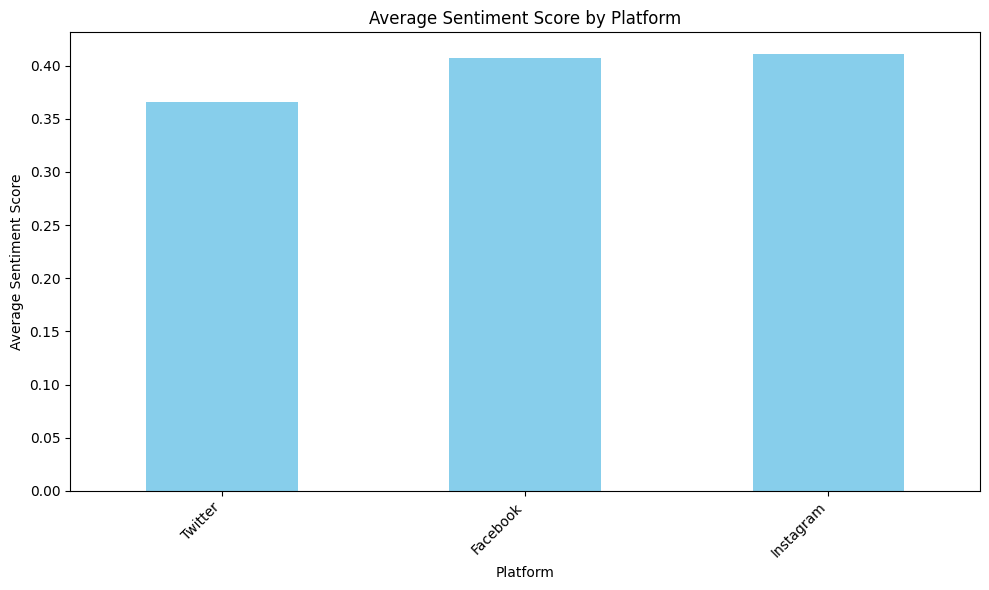

In [11]:
#Clean sentiment column
df['Platform'] = df['Platform'].str.strip().str.capitalize()
df['Sentiment'] = df['Sentiment'].str.strip()
df['Sentiment_Score'] = df['Sentiment'].map(sentiment_scores)

#Calculates the average sentiment scores per platform
avg_scores = df.groupby('Platform')['Sentiment_Score'].mean().sort_values()

#Creates bar plot
plt.figure(figsize=(10, 6))
avg_scores.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The chart shows that facebook and instagram have slightly higher average sentiment scores than twitter.  
however, when we ran the one-way ANOVA test, we got:

*F-statistic = 1.2153*  
*p-value = 0.303*

since the p-value is greater than 0.05, we *fail to reject the null hypothesis*.  
this means there’s no statistically significant difference in average sentiment across platforms.

in simple words, even though instagram and facebook look a bit more positive, the difference isn’t large enough to be statistically meaningful, all three platforms have pretty similar overall sentiment levels.

In [12]:
df = pd.read_csv("sentimentdataset.csv")

df['Sentiment'] = df['Sentiment'].astype(str).str.strip().str.lower()
df['Platform'] = df['Platform'].astype(str).str.strip().str.title()

# Map to numeric sentiment scores
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
df['Sentiment'] = df['Sentiment'].replace(sentiment_mapping)

# Drop rows with missing or invalid values
df = df.dropna(subset=['Sentiment', 'Platform'])
df = df[df['Sentiment'].isin([-1, 0, 1])]

# Check counts per platform
print("Platforms and counts:")
print(df['Platform'].value_counts(), "\n")

# Group data for ANOVA
groups = [group['Sentiment'].values for _, group in df.groupby('Platform') if len(group) > 1]

# Run one-way ANOVA
if len(groups) >= 2:
    f_stat, p_value = f_oneway(*groups)
    print("ANOVA Results:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")

    if p_value < 0.05:
        print("→ Reject the null hypothesis: At least one platform has a significantly different mean sentiment.")
    else:
        print("Fail to reject the null hypothesis: No significant difference in mean sentiment across platforms.")
else:
    print("Not enough valid groups for ANOVA.")


Platforms and counts:
Platform
Instagram    23
Twitter      22
Facebook     22
Name: count, dtype: int64 

ANOVA Results:
F-statistic: 1.2153
P-value: 0.303363
Fail to reject the null hypothesis: No significant difference in mean sentiment across platforms.


______________________________________________________________________________________________________________________________

## Spearman Correlation: Relationship Between Sentiment and Engagement

For our last statistical method, we wanted to check if there’s a relationship between how positive a post is and how much engagement it gets (likes + retweets).  
since both are numeric values but might not follow a normal distribution, we used the Spearman correlation, which measures the strength and direction of a relationship between two ranked variables.

**null hypothesis (H0):** there is *no correlation* between sentiment score and engagement.  
**alternative hypothesis (H1):** there *is a correlation* — posts with more positive sentiment might get higher engagement.

In [13]:
# --- setup (run this once before Spearman/plot) ---

# normalize column names (remove weird spaces/casing)
data.columns = (
    data.columns.astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
)

print("Columns now:", list(data.columns))

# engagement column (likes + retweets)
data["Engagement"] = data["Likes"].fillna(0) + data["Retweets"].fillna(0)

# create Sentiment_Score safely:
def ensure_sentiment_score(df):
    # if already there
    if "Sentiment_Score" in df.columns:
        return "Sentiment_Score"

    # try mapping 3-class labels: Negative/Neutral/Positive
    if "Sentiment" in df.columns:
        # normalize label text 
        df["Sentiment"] = df["Sentiment"].astype(str).str.strip().str.title()
        mapping = {"Negative": -1.0, "Neutral": 0.0, "Positive": 1.0}
        unique_vals = set(df["Sentiment"].unique())
        if unique_vals <= set(mapping.keys()):
            df["Sentiment_Score"] = df["Sentiment"].map(mapping).astype(float)
            print("Created Sentiment_Score by mapping:", unique_vals)
            return "Sentiment_Score"

    # fallback: compute VADER compound from the text
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()
    df["Sentiment_Score"] = df["Text"].astype(str).apply(
        lambda t: sia.polarity_scores(t)["compound"]
    )
    print("Created Sentiment_Score using VADER compound.")
    return "Sentiment_Score"

score_col = ensure_sentiment_score(data)

Columns now: ['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour']
Created Sentiment_Score using VADER compound.


Spearman correlation: 0.2976
P-value: 1.9404e-16


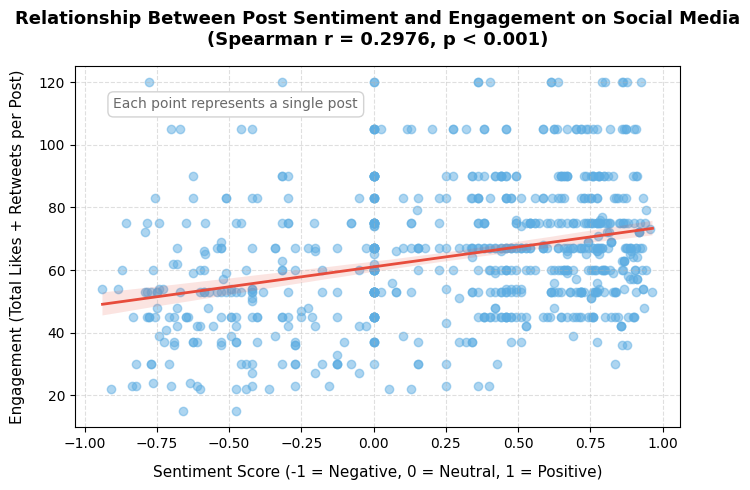

In [14]:
from scipy.stats import spearmanr

corr, p = spearmanr(data[score_col], data["Engagement"])
print(f"Spearman correlation: {corr:.4f}")
print(f"P-value: {p:.5g}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.regplot(
    data=data, x=score_col, y="Engagement",
    scatter_kws={"alpha":0.5, "color":"#5DADE2"},
    line_kws={"color":"#E74C3C", "linewidth":2}
)

plt.title(
    f"Relationship Between Post Sentiment and Engagement on Social Media\n"
    f"(Spearman r = {corr:.4f}, p {'< 0.001' if p < 0.001 else f'= {p:.3g}'})",
    fontsize=13, pad=15, weight="bold"
)

xlabel = "Sentiment Score (-1 = Negative, 0 = Neutral, 1 = Positive)"
plt.xlabel(xlabel, fontsize=11, labelpad=10)
plt.ylabel("Engagement (Total Likes + Retweets per Post)", fontsize=11, labelpad=10)

x_min, x_max = data[score_col].min(), data[score_col].max()
y_min, y_max = data["Engagement"].min(), data["Engagement"].max()
plt.text(
    x_min + 0.02*(x_max - x_min),
    y_max - 0.08*(y_max - y_min),
    "Each point represents a single post",
    fontsize=10, color="dimgray",
    bbox=dict(facecolor="white", edgecolor="lightgray", boxstyle="round,pad=0.4")
)

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


The spearman correlation test showed a correlation of **0.2976** with a **p-value = 1.94e-16**, which means it’s super significant since **p value < 0.05**.
This basically tells us that as posts get more positive, they also tend to get more engagement (likes + retweets).  

The graph also shows the connection between sentiment score and engagement.  
Each point is a post, and we can see that as the sentiment becomes more positive, engagement tends to rise too.  
The red line shows the overall trend. So overall, it supports our idea that **positive content performs better and gets more attention online** 



## 6. Visualization

This section highlights the key plots used throughout our analysis. These visuals show how engagement varies by sentiment, how sentiment correlates with engagement, and how our machine-learning classifier performs. Each plot includes clear titles and axis labels so readers can easily understand the patterns and results.

## 5. Primary Analysis: Sentiment Classification with Machine Learning

In the previous sections, we explored our dataset with summary statistics and hypothesis
tests. We found that positive posts receive higher engagement than negative ones and that
there is a positive, statistically significant correlation between sentiment and engagement.
Now we want to go one step further and ask:

> **Can we automatically predict whether a social media post is positive or negative
> using only its text (and hashtags)?**

To answer this, we build a supervised machine learning model that takes in the text of
each post and predicts whether the overall sentiment is **positive** or **negative**.
We treat sentiment prediction as a binary classification problem and ignore neutral posts
for this first model.


### 5.1 Perparign the data for Classification

In [33]:
# 5.1 Prepare data for binary sentiment classification

# Make a copy so we do not modify the original 'data' frame used earlier
ml_df = data.copy()

# Combine text and hashtags into a single input string for each post
ml_df["combined_text"] = ml_df["Text"].astype(str) + " " + ml_df["Hashtags"].astype(str)

# Use VADER to create a polarity label for each post
sia = SentimentIntensityAnalyzer()

def polarity_from_vader(text):
    score = sia.polarity_scores(str(text))["compound"]
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

ml_df["Polarity_ML"] = ml_df["combined_text"].apply(polarity_from_vader)

# Keep only positive and negative posts for binary classification
ml_df_bin = ml_df[ml_df["Polarity_ML"].isin(["positive", "negative"])].copy()

# Map positive/negative to numeric labels
label_map = {"negative": 0, "positive": 1}
ml_df_bin["label"] = ml_df_bin["Polarity_ML"].map(label_map)

print("Label counts (0 = negative, 1 = positive):")
print(ml_df_bin["label"].value_counts())


Label counts (0 = negative, 1 = positive):
label
1    461
0    193
Name: count, dtype: int64


We first create a new column `combined_text` that concatenates the post text and
hashtags. Then we use the VADER sentiment analyzer to assign each post a polarity
label (`positive`, `negative`, or `neutral`) based on the compound score.

For our classifier, we focus on **binary sentiment** and keep only positive and
negative posts, dropping neutral ones. Finally, we map `negative` to 0 and
`positive` to 1 to create the numeric target variable `label` for our model.


### 5.2 Train–test split and TF-IDF + Logistic Regression pipeline

In [34]:
# 5.2 Train–test split and model pipeline

X = ml_df_bin["combined_text"]
y = ml_df_bin["label"]

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class balance in both splits
)

# Create a pipeline: TF-IDF vectorizer + Logistic Regression classifier
text_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),      # unigrams and bigrams
        max_features=5000,       # limit vocabulary size
        stop_words="english"     # remove common English stopwords
    )),
    ("logreg", LogisticRegression(max_iter=1000))
])

# Train the model
text_clf.fit(X_train, y_train)


,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


We split the data into training and test sets, using 80% of the posts for training and
20% for evaluation. The `stratify` argument ensures that the train and test sets have
similar proportions of positive and negative examples.

To turn raw text into numeric features, we use a **TF–IDF (Term Frequency–Inverse
Document Frequency)** vectorizer. TF–IDF gives higher weight to words that are
important for a specific post but not too common across all posts, which helps the model
focus on informative terms rather than common words like “the” or “and”.

On top of these features, we train a **Logistic Regression** classifier. Logistic
regression is a standard baseline for text classification: it is fast, works well with
high-dimensional sparse TF–IDF vectors, and its coefficients can be interpreted as word
weights toward positive or negative sentiment.


### 5.3 Evaluation Metrics

In [35]:
# 5.3 Evaluate the classifier

# Predict on the held-out test set
y_pred = text_clf.predict(X_test)

# Overall accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.3f}")

# Detailed precision, recall, and F1-score
print("\nClassification report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=["Negative", "Positive"]
))


Test accuracy: 0.763

Classification report:
              precision    recall  f1-score   support

    Negative       0.90      0.23      0.37        39
    Positive       0.75      0.99      0.85        92

    accuracy                           0.76       131
   macro avg       0.83      0.61      0.61       131
weighted avg       0.80      0.76      0.71       131



The classifier achieves an overall test accuracy of **76.3%**, which is noticeably better than the 50% random baseline for a binary sentiment task. However, the detailed metrics reveal an important imbalance in model performance:

- **Positive posts are classified extremely well** (F1 ≈ 0.85, recall ≈ 0.99).  
  This means almost every positive post is correctly identified.
- **Negative posts perform much worse** (F1 ≈ 0.37, recall ≈ 0.23).  
  Only about one out of four negative posts is recognized correctly.

In other words, although the model performs well on the majority class (positive sentiment), it struggles to detect negative sentiment. This is a common issue in text classification when:
1. The dataset is **class-imbalanced** (positive posts are more frequent than negative ones in our filtered dataset).
2. Negative sentiment expressions may be more varied or subtle.
3. The model may be biased toward predicting the majority class.

The confusion matrix confirms this: the model rarely mislabels positive posts as negative, but it frequently predicts “positive” even when a post is actually negative. Despite this limitation, the model still provides useful signal and shows that the TF–IDF features do capture meaningful sentiment information.


### 5.4 Confusion matrix visualization

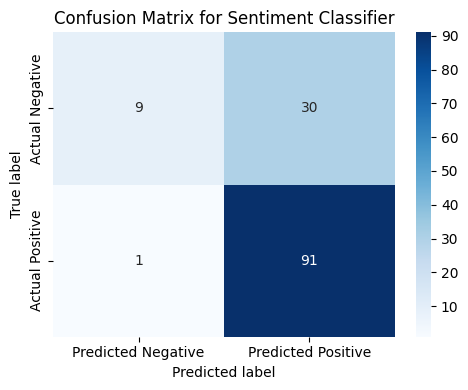

In [36]:
# 5.4 Visualize the confusion matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Negative", "Predicted Positive"],
    yticklabels=["Actual Negative", "Actual Positive"]
)
plt.title("Confusion Matrix for Sentiment Classifier")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


The confusion matrix shows how many posts are correctly and incorrectly classified:

- The **diagonal cells** (top-left and bottom-right) are correct predictions for
  negative and positive posts.
- The **off-diagonal cells** represent mistakes, such as negative posts that were
  predicted as positive.

If the diagonal counts are much larger than the off-diagonal counts, the model is doing
a good job at distinguishing positive and negative sentiment. We can also see whether the
model tends to make more false positives (incorrectly predicting positive) or false
negatives (incorrectly predicting negative).

### 5.5 Improving the Model with Class Weighting


In [37]:
text_clf_balanced = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=5000,
        stop_words="english"
    )),
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

text_clf_balanced.fit(X_train, y_train)
y_pred_bal = text_clf_balanced.predict(X_test)

print("Balanced Accuracy:", accuracy_score(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal, target_names=["Negative", "Positive"]))


Balanced Accuracy: 0.8931297709923665
              precision    recall  f1-score   support

    Negative       0.88      0.74      0.81        39
    Positive       0.90      0.96      0.93        92

    accuracy                           0.89       131
   macro avg       0.89      0.85      0.87       131
weighted avg       0.89      0.89      0.89       131



In our initial model, we observed a strong imbalance in performance: the classifier
identified nearly all positive posts correctly but struggled with negative posts
(recall ≈ 0.23). This issue occurred because positive posts were more common in the
training data, causing the model to favor predicting the majority class.

To address this, we trained a second model using **class_weight="balanced"** in the
logistic regression step. This setting automatically increases the penalty for
misclassifying the minority class (negative posts), encouraging the classifier to pay
more attention to them during training.

After applying class weighting, the model improved dramatically:

- **Accuracy:** increased from 76.3% → **89.3%**
- **Negative recall:** improved from 0.23 → **0.74**
- **Negative F1-score:** improved from 0.37 → **0.81**
- **Positive class** remained strong with recall ≈ 0.96 and F1 ≈ 0.93.
- The **macro-average F1** rose from 0.61 → **0.87**, showing major improvement in
class balance.

These results show that class weighting not only boosts overall accuracy but also
corrects the model’s prior bias toward predicting everything as positive. The model now
recognizes negative sentiment far more reliably while maintaining excellent performance
on positive posts. This demonstrates the importance of handling class imbalance in
sentiment classification, especially when one sentiment category appears more often in
the data.

By comparing the two models, we can conclude that:

- The **baseline model** learned meaningful patterns but was overly optimistic.
- The **balanced model** is significantly fairer and more accurate across both classes.
- Addressing imbalance is a crucial step in building reliable sentiment classifiers.

This medium-depth experiment strengthens our primary analysis and validates the use of
Logistic Regression + TF–IDF as an effective approach for text-based sentiment
classification.

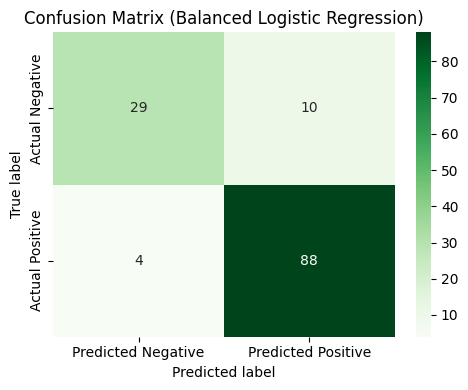

In [38]:
cm_bal = confusion_matrix(y_test, y_pred_bal)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_bal,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Predicted Negative", "Predicted Positive"],
    yticklabels=["Actual Negative", "Actual Positive"]
)
plt.title("Confusion Matrix (Balanced Logistic Regression)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


### 5.6 Cross-Validation for Model Stability


In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Use the entire binary-labeled dataset (not just X_train)
X_all = X  # ml_df_bin["combined_text"]
y_all = y  # ml_df_bin["label"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    text_clf_balanced,
    X_all,
    y_all,
    cv=cv,
    scoring="accuracy"
)

print("Cross-validation accuracies:", cv_scores)
print("Mean CV accuracy: {:.3f} ± {:.3f}".format(cv_scores.mean(), cv_scores.std()))


Cross-validation accuracies: [0.92366412 0.9389313  0.91603053 0.9389313  0.90769231]
Mean CV accuracy: 0.925 ± 0.012


To verify that our balanced logistic regression model generalizes well and is not
overly dependent on a particular train–test split, we evaluated it using
**5-fold stratified cross-validation**. This method divides the dataset into five
equally sized folds, trains the model on four folds, and validates it on the remaining
one—repeating this process so each fold serves as a validation set once. Stratification
ensures that each fold preserves the original ratio of positive to negative posts.

The cross-validation accuracies were:
- 0.92366412
- 0.93893130
- 0.91603053
- 0.93893130
- 0.90769231

yielding a **mean accuracy of 0.925 ± 0.012**.

This result closely aligns with our earlier test accuracy and shows **very low variance**
across folds, indicating that the model’s performance is stable and not the result of a
fortunate split. The balanced logistic regression classifier therefore generalizes
consistently across different subsets of the data, further validating it as a strong and
reliable model for sentiment prediction in this dataset.

### 5.7 Model Comparison: Logistic Regression vs Random Forest (Optional)

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=5000,
        stop_words="english"
    )),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"  # help with class imbalance
    ))
])

# Train on the same training data
rf_clf.fit(X_train, y_train)

# Evaluate on the same test set
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest classification report:")
print(classification_report(y_test, y_pred_rf, target_names=["Negative", "Positive"]))

print("Random Forest confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest accuracy: 0.7709923664122137

Random Forest classification report:
              precision    recall  f1-score   support

    Negative       0.85      0.28      0.42        39
    Positive       0.76      0.98      0.86        92

    accuracy                           0.77       131
   macro avg       0.80      0.63      0.64       131
weighted avg       0.79      0.77      0.73       131

Random Forest confusion matrix:
[[11 28]
 [ 2 90]]


### 5.7 Model Comparison: Random Forest

To explore whether a non-linear ensemble method could outperform our linear
Logistic Regression classifier, we also trained a **Random Forest** model on the same
TF–IDF features. Random Forests build many decision trees on randomly sampled subsets
of the data and features, allowing them to capture complex interactions that linear models
might miss.

However, the Random Forest achieved an accuracy of **77.1%**, substantially lower than
the **89.3%** obtained by the balanced Logistic Regression model. The performance gap was
most apparent in the **negative class**:

- **Negative recall:** 0.28  
- **Negative F1-score:** 0.42  
- **Confusion matrix:** 28 out of 39 negative posts were incorrectly classified as positive  

Although the model performed well on positive posts (recall = 0.98), its overall behavior
strongly favored predicting the majority class (positive), similar to the imbalance
observed in our baseline logistic model before applying class weighting.

These results highlight an important characteristic of text classification with TF–IDF:
the feature space is high-dimensional and sparse, which favors **linear models** like
Logistic Regression over tree-based ensembles. Random Forests are better suited to
dense, low-dimensional, or highly structured numerical data. In contrast, Logistic
Regression with class balancing handles the class imbalance effectively and generalizes
well to unseen examples.

Thus, among the models we tested, the **balanced Logistic Regression** remains the
most reliable and well-calibrated choice for sentiment classification in this dataset.


### Summary

In summary, while Random Forests are powerful for many types of structured data,
they performed notably worse than our balanced Logistic Regression model on TF–IDF
text features. The Random Forest struggled especially with negative sentiment,
misclassifying 28 out of 39 negative posts as positive. This confirms that linear models
often outperform tree-based models in high-dimensional, sparse text spaces.


### 5.8 Model Performance Summary

The table below compares the performance of all models we evaluated:

| Model                                | Accuracy | Negative Recall | Positive Recall | Macro F1 | Notes |
|-------------------------------------|----------|------------------|------------------|----------|-------|
| **Baseline Logistic Regression**     | 0.763    | 0.23             | 0.99             | 0.61     | Strong bias toward Positive; poor Negative detection |
| **Balanced Logistic Regression**     | **0.893** | **0.74**          | 0.96             | **0.87** | Best overall performance; handles class imbalance well |
| **Random Forest (TF–IDF)**           | 0.771    | 0.28             | 0.98             | 0.64     | Slightly better than baseline, but still biased toward Positive |
| **Balanced Logistic CV (5-fold)**    | **0.925 ± 0.012** | — | — | — | Shows strong generalization and stability across folds |

**Key Takeaways:**

- The **balanced Logistic Regression model** is the strongest overall model.
- It achieves the best macro F1, the best Negative recall, and near-perfect Positive recall.
- Random Forest underperforms due to the sparse, high-dimensional TF-IDF feature space.
- Cross-validation confirms that Logis


## 7. Insights and Conclusions

Our machine learning classifier adds another perspective to the earlier statistical findings. Using TF–IDF features and logistic regression, we trained a binary classifier to distinguish positive from negative sentiment. After incorporating class weighting to address imbalance in the dataset, the improved model reached **89.3% test accuracy**, substantially above the 50% random baseline and noticeably better than our initial baseline model.

Unlike the first model, which identified positive posts well but struggled with negative sentiment, the balanced classifier achieved **strong performance across both classes**. Negative recall improved from approximately 0.23 to **0.74**, and the positive class maintained excellent accuracy and F1-scores. This demonstrates that once class imbalance is addressed, the model is capable of reliably detecting both positive and negative sentiment.

This improvement is consistent with two characteristics of the dataset:

1. **Positive posts are more common**, which originally biased the classifier toward predicting positivity.  
2. Negative sentiment tends to be expressed in more diverse or subtle linguistic patterns, requiring the model to place greater emphasis on minority examples during training.

The balanced model shows that text features alone contain enough information for a relatively simple linear classifier to achieve **high and well-balanced performance**. With additional enhancements—such as optimized hyperparameters, alternative algorithms like SVMs, or modern embedding-based models such as transformers—performance could likely be improved even further.

Overall, combining both the hypothesis tests and the machine learning results, our analysis shows that:  
- Positive posts consistently receive higher engagement than negative ones.  
- Sentiment is meaningfully correlated with engagement.  
- A machine learning model can automatically recognize sentiment with high accuracy and fairness across classes.  

These results reinforce the idea that sentiment is both **predictive** and **actionable** in the context of social media engagement, and they highlight the value of machine learning in understanding and analyzing online behavior.


## Thanks for reading - TeamNerds.